### Import libraries

In [1]:
# Fix randomness and hide warnings
seed = 420

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import math

import logging

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [3]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

### Connect to Drive

In [4]:
from google.colab import drive
drive.mount('/gdrive')
os.chdir('/gdrive/My Drive/Colab Notebooks/Challenge 2')

Mounted at /gdrive


### Unzip data

In [ ]:
#!unzip training_dataset.zip

### Load data

In [5]:
dataset = np.load("training_data.npy", allow_pickle=True)
valid_per = np.load("valid_periods.npy", allow_pickle=True)
cat = np.load("categories.npy", allow_pickle=True)
print(dataset.shape)
print(valid_per.shape)
print(cat.shape)

(48000, 2776)
(48000, 2)
(48000,)


### Inspect Data

In [6]:
unique_elements, counts = np.unique(cat, return_counts=True)
element_counts = dict(zip(unique_elements, counts))
for element, count in element_counts.items():
    print(f"Element {element}: Count {count}")

Element A: Count 5728
Element B: Count 10987
Element C: Count 10017
Element D: Count 10016
Element E: Count 10975
Element F: Count 277


Text(0.5, 1.0, 'C')

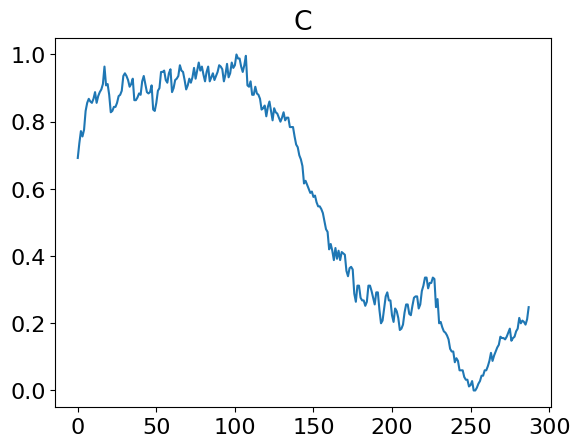

In [7]:
num = 30000
#print(np.linspace(valid_per[num,0], valid_per[num,1]))
plt.plot(dataset[num, np.arange(valid_per[num,0], valid_per[num,1], dtype=int)])
plt.title(cat[num])

In [8]:
dat = np.zeros(len(cat))
n_dataset = {}
for el in unique_elements:
  start = -1
  end = 0
  for i in range(len(cat)):
    if cat[i] == el:
      if start == -1:
        start = i
      end = i
  n_dataset[el] = dataset[start:end, :]
  n_dataset[el+'t'] = valid_per[start:end, :]

In [9]:
max_length = len(cat)
line = 0
for i in range(len(cat)):
  if max_length > valid_per[i, 1]-valid_per[i, 0]:
    max_length = valid_per[i, 1]-valid_per[i, 0]
    line = i
print(max_length, line)

24 47852


In [10]:
mean = np.zeros(len(unique_elements))
variance = np.zeros(len(unique_elements))
for i, el in enumerate(unique_elements):
  mean[i] = np.mean(n_dataset[el+'t'][:, 1]-n_dataset[el+'t'][:, 0])
  variance[i] = np.var(n_dataset[el+'t'][:, 1]-n_dataset[el+'t'][:, 0])
  print(f"Element {el}: Mean {mean[i]} Std dev {np.sqrt(variance[i])}")

Element A: Mean 278.211454513707 Std dev 109.2650103554036
Element B: Mean 165.95357728017476 Std dev 116.13647608799306
Element C: Mean 208.1561501597444 Std dev 146.28606221686587
Element D: Mean 217.00748876684972 Std dev 149.16472997606039
Element E: Mean 163.05622380171314 Std dev 127.9878671656014
Element F: Mean 195.17391304347825 Std dev 153.30423068381918


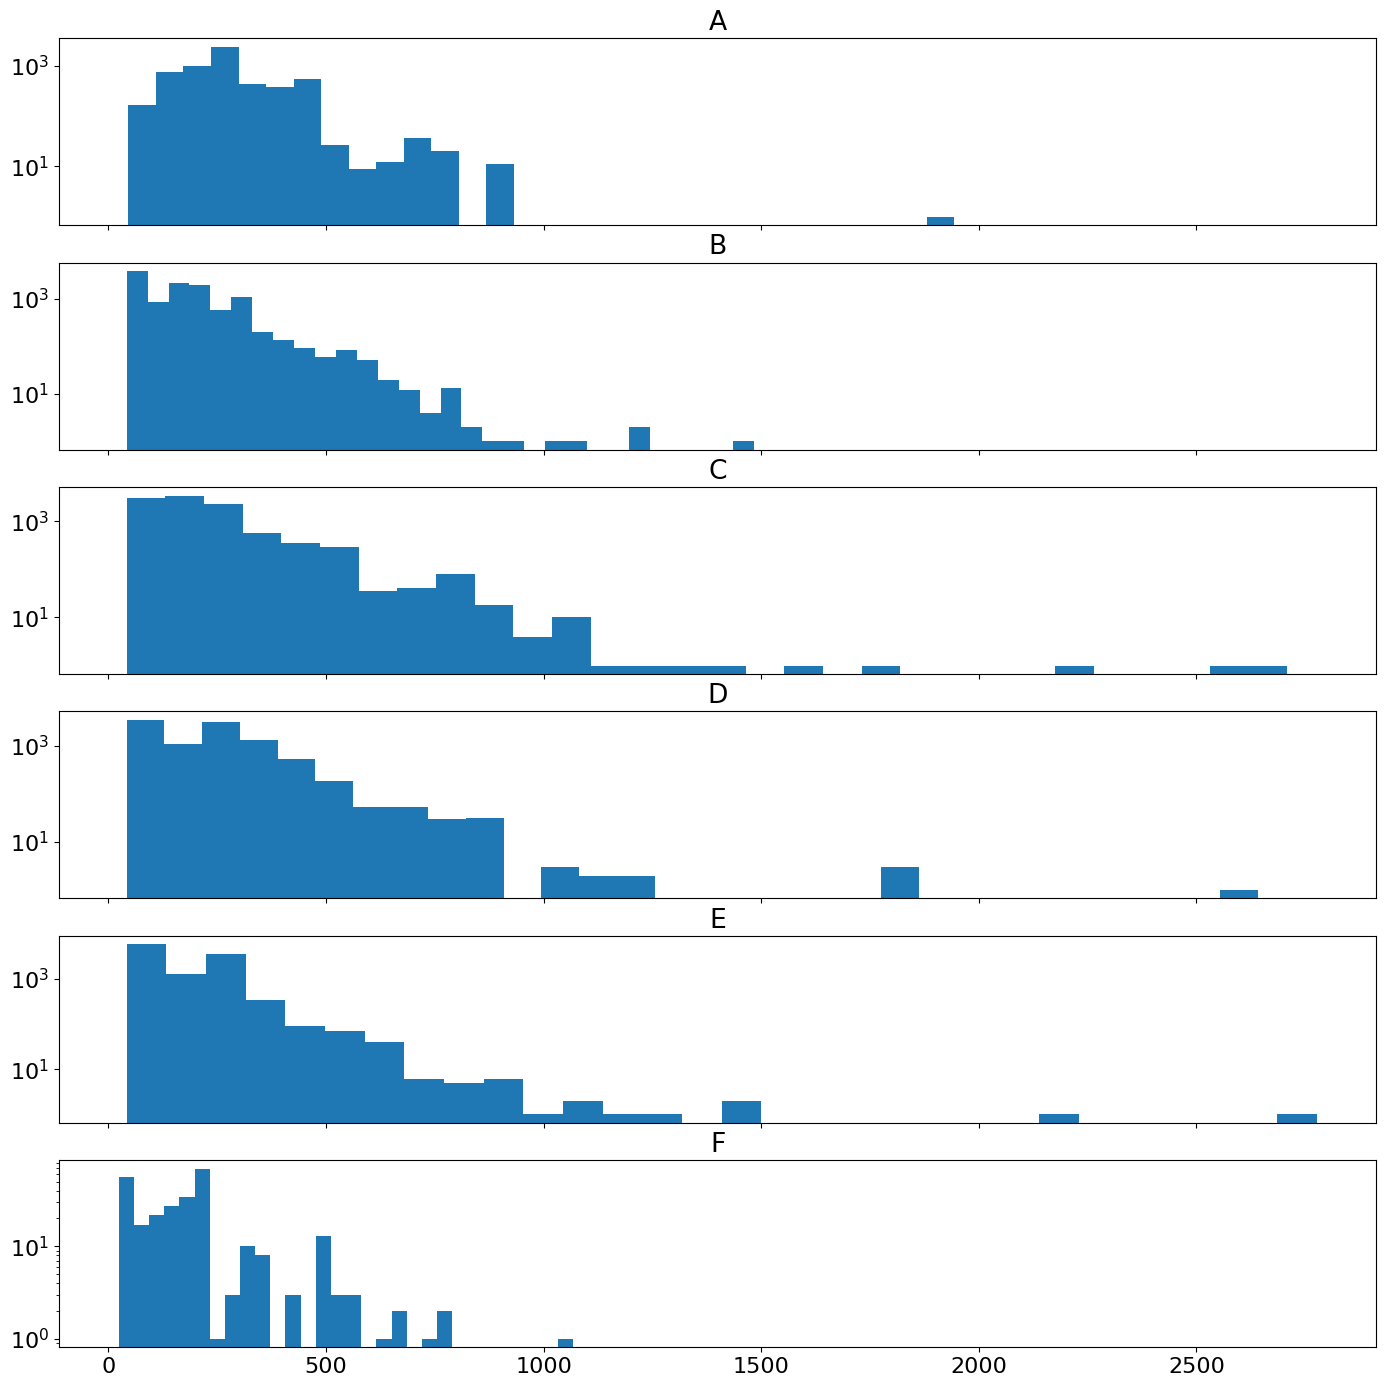

In [11]:
figs, axs = plt.subplots(len(unique_elements), 1, sharex=True, figsize=(17,17))
for i, el in enumerate(unique_elements):
  axs[i].hist(n_dataset[el+'t'][:, 1]-n_dataset[el+'t'][:, 0], bins=30, log=True)
  axs[i].set_title(el)
plt.show()

In [12]:
co = 0
for i in range(len(cat)):
    if valid_per[i, 1]-valid_per[i, 0] > 200+9:
        co = co + 1
print(f"{co/len(cat)*100}%")

45.7%


### Sequential Test-Validation-Train split

In [13]:
test_per = 0.2
# the split is: 60% training, 20% validation, 20% testing
tv_size = math.ceil(len(dataset)*test_per)

# from dataset is picked tot timeseries randomically for test
random_indices_test = np.random.choice(len(dataset), size=tv_size, replace=False)
# results is the test dataset, valid_periods and categories
X_test_raw = dataset[random_indices_test]
valid_per_test = valid_per[random_indices_test]
cat_test = cat[random_indices_test]

# defining the remaining part for validation and training
remain_indices = np.setdiff1d(np.arange(len(dataset)), random_indices_test)
X_train_val = dataset[remain_indices]
valid_per_train_val = valid_per[remain_indices]
cat_train_val = cat[remain_indices]

# from dataset is picked tot timeseries randomically for validation
random_indices_valid = np.random.choice(len(X_train_val), size=tv_size, replace=False)
# results is the validation dataset, valid_periods and categories
X_valid_raw = X_train_val[random_indices_valid]
valid_per_valid = valid_per_train_val[random_indices_valid]
cat_valid = cat_train_val[random_indices_valid]

# defining the remaining part for training
remain_indices = np.setdiff1d(np.arange(len(X_train_val)), random_indices_valid)
X_train_raw = X_train_val[remain_indices]
valid_per_train = valid_per_train_val[remain_indices]
cat_train = cat_train_val[remain_indices]

print(X_train_raw.shape, X_test_raw.shape, X_valid_raw.shape)

(28800, 2776) (9600, 2776) (9600, 2776)


For only validation-training with no test

In [14]:
test_per = 0.2
# the split is: 80% training, 20% validation
tv_size = math.ceil(len(dataset)*test_per)

# from dataset is picked tot timeseries randomically for validation
random_indices_test = np.random.choice(len(dataset), size=tv_size, replace=False)
# results is the validation dataset, valid_periods and categories
X_valid_raw = dataset[random_indices_test]
valid_per_valid = valid_per[random_indices_test]
cat_valid = cat[random_indices_test]

# defining the remaining part for training
remain_indices = np.setdiff1d(np.arange(len(dataset)), random_indices_test)
X_train_raw = dataset[remain_indices]
valid_per_train = valid_per[remain_indices]
cat_train = cat[remain_indices]

print(X_train_raw.shape, X_valid_raw.shape)

(38400, 2776) (9600, 2776)


### Construct timeseries for training

In [15]:
# adaptation of the function constructed by the professor for our purposes
# here the padding is full zeros
def build_sequences(df, valid, cat, window=200, stride=20, telescope=9):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    n_stride = stride

    # for each timeseries
    for i in range(len(df)):
        # cutting the interested part
        val = range(valid[i, 0], valid[i, 1])
        temp_df = df[i, val]
        temp_label = df[i, val]

        # using for F-timeseries a stride 10x smaller
        if cat[i] == 'F':
          stride = int(n_stride/10)
        else:
          stride = n_stride

        # if the resulting timeseries is smaller than the window+telescope, pad the difference
        if len(temp_df)<window+telescope:
            padding_len = window + telescope - len(temp_df)
            padding = np.zeros((padding_len), dtype='float32')
            temp_df = np.concatenate((padding,temp_df))
            temp_label = np.concatenate((padding,temp_label))
            assert len(temp_df) % (window+telescope) == 0

        else:
            padding_check = len(temp_df)%window

            if(padding_check != 0):
                # Compute padding length
                padding_len = window - len(temp_df)%window
                padding = np.zeros((padding_len), dtype='float32')
                temp_df = np.concatenate((padding,temp_df))
                temp_label = np.concatenate((padding,temp_label))
                assert len(temp_df) % window == 0

        for idx in np.arange(0,len(temp_df)-window-telescope,stride):
            dataset.append(temp_df[idx:idx+window])
            labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [16]:
# in this case the padding is the last possible repeated sequence
def build_sequences_no_pad(df, valid, cat, window=200, stride=20, telescope=9):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    n_stride = stride

    # for each timeseries
    for i in range(len(df)):
        # cutting the interested part
        val = range(valid[i, 0], valid[i, 1])
        temp_df = df[i, val]
        temp_label = df[i, val]

        # using for F-timeseries a stride 10x smaller
        if cat[i] == 'F':
          stride = int(n_stride/10)
        else:
          stride = n_stride

        # if the resulting timeseries is smaller than the window+telescope, pad the difference
        if len(temp_df)<window+telescope:
            data_len = len(temp_df)
            padding_len = window + telescope - data_len
            # expanding ante-tempore the timeseries to the final size
            temp_df = np.concatenate((np.zeros(padding_len, dtype='float32'),temp_df))
            # defining a for loop in case is needed multiple copies of the timeseries in the padding
            for i in range(math.floor(padding_len/data_len)):
                # compute the remaining part after the iteration of padding
                scarto = min(padding_len-(i+1)*data_len, 0)
                # copying the padding from the timeseries
                temp_df[max(padding_len-(i+1)*data_len, 0):padding_len-i*data_len] = temp_df[-data_len-scarto:len(temp_df)]
            temp_label = temp_df
            assert len(temp_df) % (window+telescope) == 0

        else:
            padding_check = len(temp_df)%window

            if(padding_check != 0):
                # Compute padding length
                data_len = len(temp_df)
                padding_len = window - data_len%window
                temp_df = np.concatenate((np.zeros(padding_len, dtype='float32'),temp_df))
                # copying the padding from the timeseries, no need a more complicate for loop for obvious reasons
                temp_df[0:padding_len] = temp_df[-data_len:-data_len+padding_len]
                temp_label = temp_df
                assert len(temp_df) % window == 0

        for idx in np.arange(0,len(temp_df)-window-telescope,stride):
            dataset.append(temp_df[idx:idx+window])
            labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [17]:
telescope_val = 18
stride_val = 10

In [18]:
# the 1 refers to the fact that is not our final training dataset ecc, it needs to be expanded to be feeded in the model
X_train1, y_train1 = build_sequences(X_train_raw, valid_per_train, cat_train, stride=stride_val, telescope=telescope_val)
X_test1, y_test1 = build_sequences(X_test_raw, valid_per_test, cat_test, stride=stride_val, telescope=telescope_val)
X_valid1, y_valid1 = build_sequences(X_valid_raw, valid_per_valid, cat_valid, stride=stride_val, telescope=telescope_val)
X_train1.shape, y_train1.shape, X_test1.shape, y_test1.shape, X_valid1.shape, y_valid1.shape

((384041, 200), (384041, 18))

In [19]:
X_train = np.expand_dims(X_train1, axis=-1)
y_train = np.expand_dims(y_train1, axis=-1)
X_test = np.expand_dims(X_test1, axis=-1)
y_test = np.expand_dims(y_test1, axis=-1)
X_valid = np.expand_dims(X_valid1, axis=-1)
y_valid = np.expand_dims(y_valid1, axis=-1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_valid.shape, y_valid.shape

((384041, 200, 1), (384041, 18, 1))

### Inspecting the sequences

In [20]:
def inspect_multivariate(X, y, telescope):
    idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(5, 1, sharex=True, figsize=(17,17))
    for i in range(5):
        axs[i].plot(np.arange(len(X[idx+i,:,0])), X[idx+i,:,0])
        axs[i].scatter(np.arange(len(X[idx+i,:,0]), len(X_train[idx+i,:,0])+telescope), y[idx+i,:,0], color='orange')
        axs[i].set_title(f"{idx+i}")
        #axs[i].set_ylim(0,1)
    plt.show()

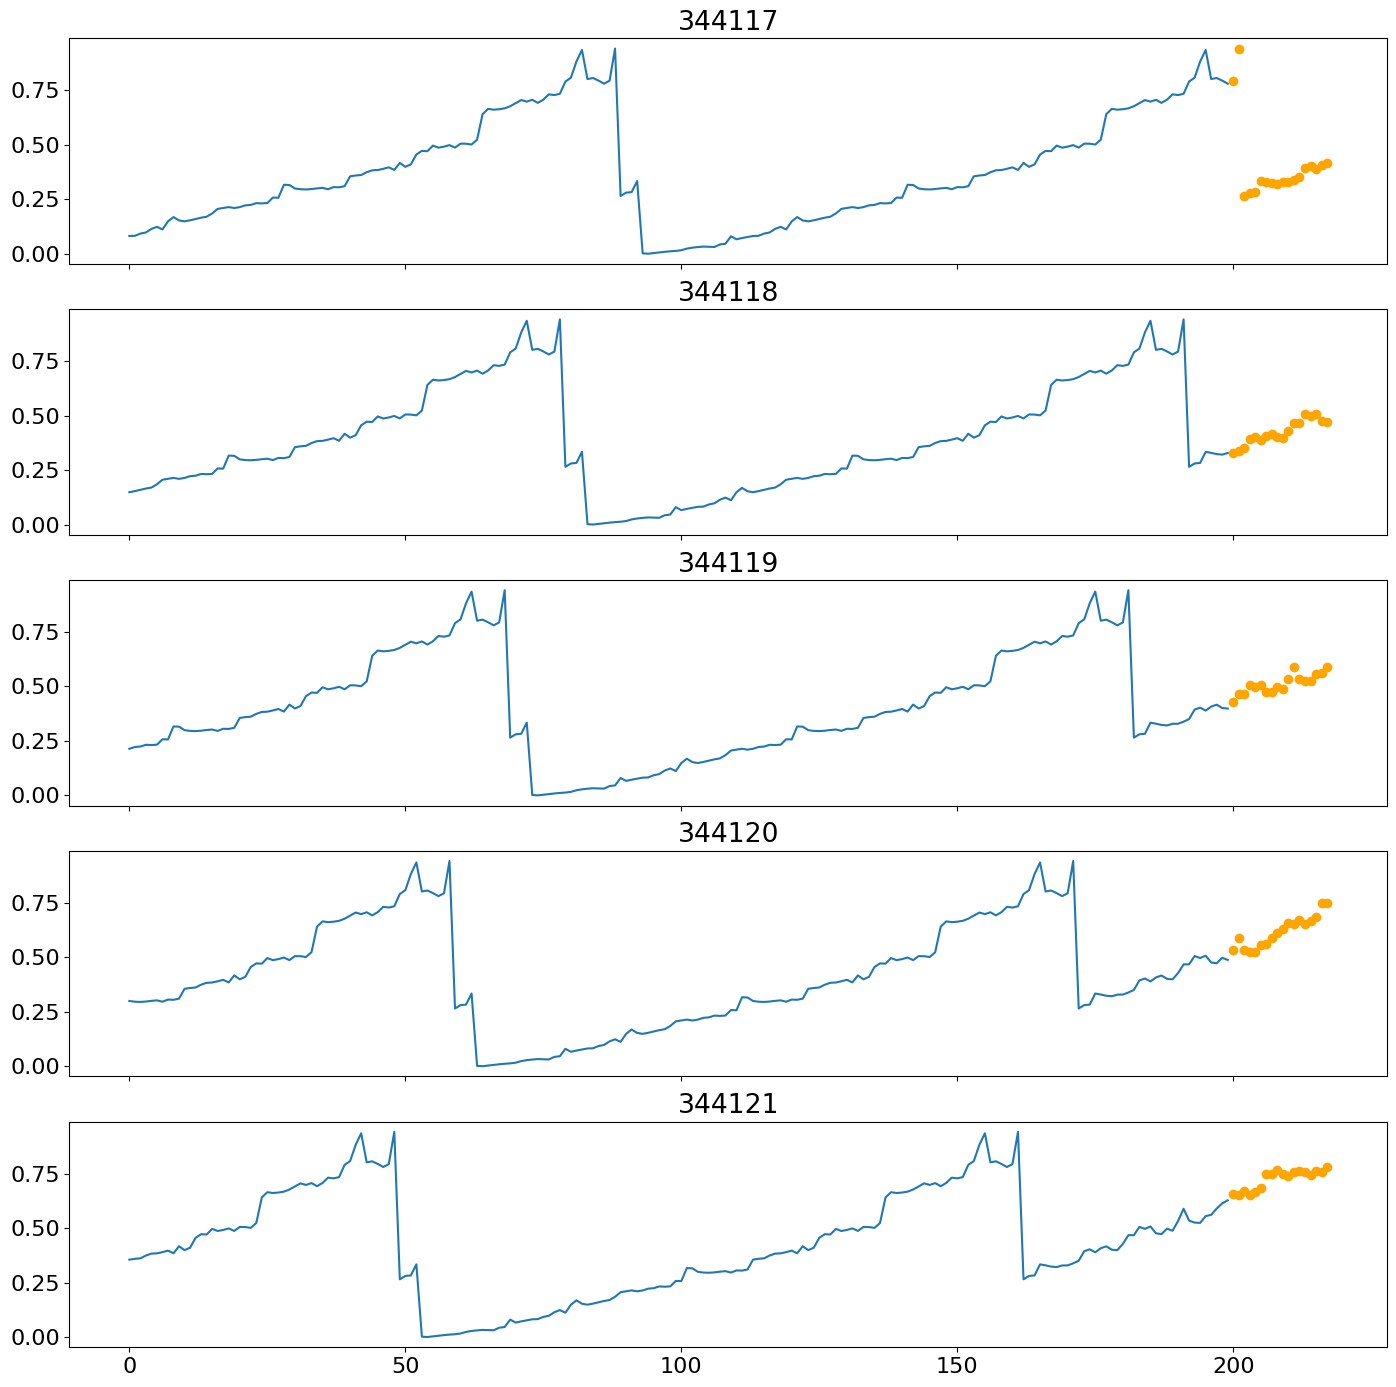

In [21]:
inspect_multivariate(X_train, y_train, 18)

### Monovariate Forecating (Direct)

In [22]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 256
epochs = 200
print(input_shape)

(200, 1)


In [ ]:
# first model, as the professor made
def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0],

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

In [50]:
# our best model with no attention and no subdivisions between categories
def build_CONV_LSTM_model_dense(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0],

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 100 units
    x = tfkl.Bidirectional(tfkl.LSTM(100, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    # Add a 1D Convolution layer with 200 filters and a kernel size of 3
    x = tfkl.Conv1D(200, 3, padding='same', activation='relu', name='conv1')(x)

    # Add a convolution layer to greately reduce the size
    x = tfkl.Conv1D(output_shape[1], 3, padding='same', name='conv2')(x)

    # Flatten layer for the dense one
    x = tfkl.Flatten(name='flatten')(x)

    x = tfkl.Dropout(0.5, name='dropout1')(x)

    x = tfkl.Dense(output_shape[0], activation='relu', name='dense')(x)

    # Reshaping for the desired shape
    output_layer = tfkl.Reshape((output_shape[0], 1), name='reshape')(x)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

In [ ]:
# our second best model, same as before but with no dropout and another dense layer
def build_CONV_LSTM_model_2dense(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(100, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(200, 3, padding='same', activation='relu', name='conv1')(x)

    # Add a final Convolution layer to match the desired output shape
    x = tfkl.Conv1D(output_shape[1]*2, 3, padding='same', name='conv2')(x)

    # Flatten layer for the dense ones
    x = tfkl.Flatten(name='flatten')(x)

    x = tfkl.Dense(256, activation='relu', name='dense1')(x)

    x = tfkl.Dense(output_shape[0], activation='relu', name='dense2')(x)

    # Reshaping for the desired shape
    output_layer = tfkl.Reshape((output_shape[0], 1), name='reshape')(x)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

In [ ]:
# model done for testing the adding of another biLSTM layer
def build_CONV_2LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm1')(input_layer)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv1')(x)

    # Add another Bidirectional LSTM layer with 32 units
    x = tfkl.Bidirectional(tfkl.LSTM(32, return_sequences=True, name='lstm'), name='bidirectional_lstm2')(x)

    # Add a 1D Convolution layer with 64 filters and a kernel size of 3
    x = tfkl.Conv1D(64, 3, padding='same', activation='relu', name='conv2')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

In [ ]:
# Tentative of using the attention layer in keras (not mentioned in the report since is not very efficient)
def build_CONV_LSTM_model_Att(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm1')(input_layer)

    attention_output = tfkl.Attention()([x, x])

    x = tfkl.Concatenate(axis=-1)([x, attention_output])

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv1')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

In [ ]:
# Another way to implement Attention, but with 3 final dense layers
def build_LSTM_model_Att_dense(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm1')(input_layer)

    attention_output = tfkl.Attention()([x, x])

    x = tfkl.Concatenate(axis=-1)([x, attention_output])

    x = tfkl.Flatten()(x)

    conc_shape = x.shape[-1]
    num_den = 3
    for i in range(num_den):
      x = tfkl.Dense(math.floor(output_shape[0]*(4**(num_den-i-1))))(x)#(conc_shape/output_shape[0])**(1-(i+1)/num_den)))(x)

    output_layer = tfkl.Reshape((output_shape[0], 1))(x)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 bidirectional_lstm (Bidire  (None, 200, 200)          81600     
 ctional)                                                        
                                                                 
 conv1 (Conv1D)              (None, 200, 200)          120200    
                                                                 
 conv2 (Conv1D)              (None, 200, 1)            601       
                                                                 
 flatten (Flatten)           (None, 200)               0         
                                                                 
 dropout1 (Dropout)          (None, 200)               0         
                                                   

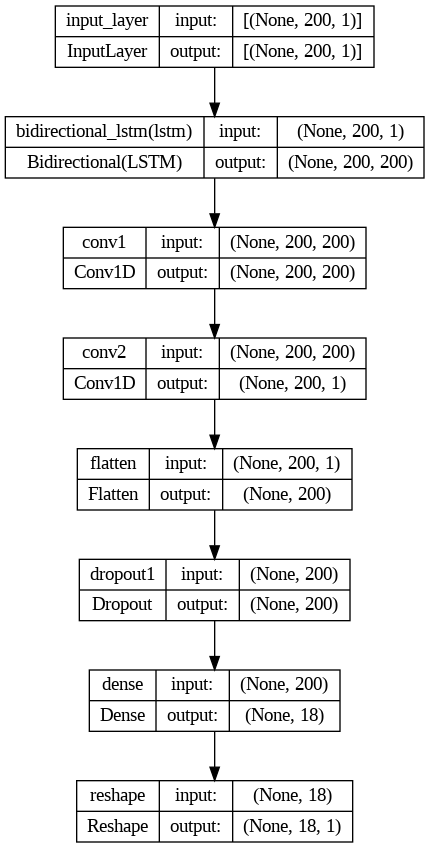

In [23]:
model = build_CONV_LSTM_model_dense(input_shape, output_shape)
#model = tfk.models.load_model('Checkpoints/base_model.keras')
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(5e-4))
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [24]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_valid, y_valid),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=5e-5, patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=20, factor=0.1, min_lr=1e-5),
        tfk.callbacks.ModelCheckpoint(filepath='Checkpoints/base_model.keras') # we're using checkpoints
    ]
).history

Epoch 1/200
1501/1501 [==============================] - 84s 50ms/step - loss: 0.0076 - val_loss: 0.0067 - lr: 5.0000e-04
Epoch 2/200
1501/1501 [==============================] - 75s 50ms/step - loss: 0.0075 - val_loss: 0.0067 - lr: 5.0000e-04
Epoch 3/200
1501/1501 [==============================] - 77s 52ms/step - loss: 0.0075 - val_loss: 0.0067 - lr: 5.0000e-04
Epoch 4/200
1501/1501 [==============================] - 78s 52ms/step - loss: 0.0075 - val_loss: 0.0067 - lr: 5.0000e-04
Epoch 5/200
1501/1501 [==============================] - 78s 52ms/step - loss: 0.0074 - val_loss: 0.0067 - lr: 5.0000e-04
Epoch 6/200
1501/1501 [==============================] - 79s 52ms/step - loss: 0.0074 - val_loss: 0.0068 - lr: 5.0000e-04
Epoch 7/200
1501/1501 [==============================] - 79s 52ms/step - loss: 0.0074 - val_loss: 0.0067 - lr: 5.0000e-04
Epoch 8/200
1501/1501 [==============================] - 79s 52ms/step - loss: 0.0074 - val_loss: 0.0068 - lr: 5.0000e-04
Epoch 9/200
1501/1501 [=

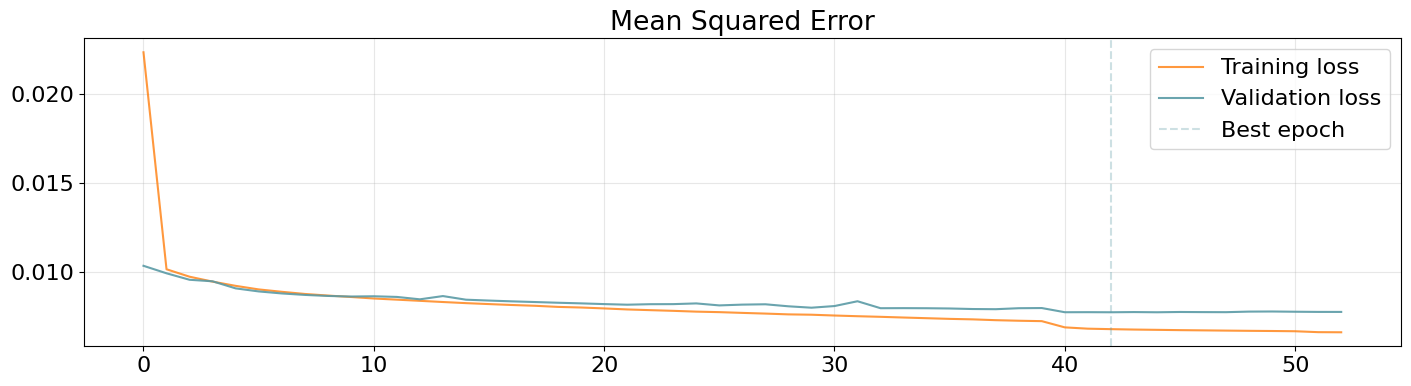

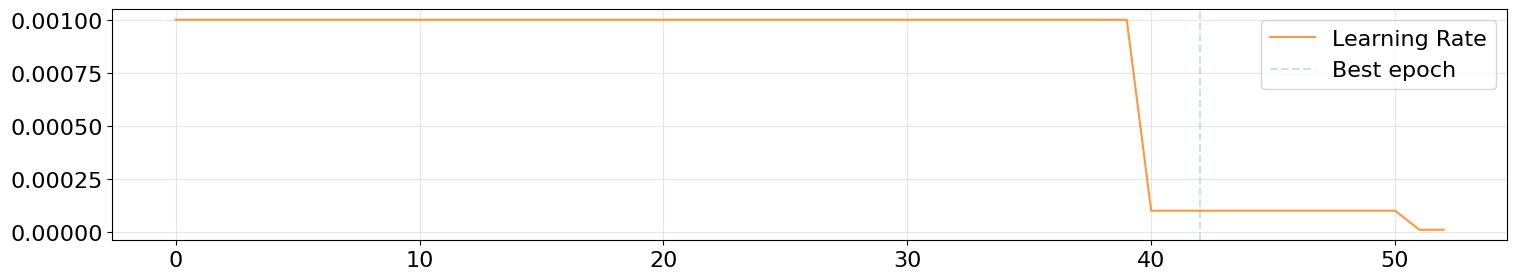

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [25]:
model.save('DirectForecasting12.h5')

Test evaluation

In [ ]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (97317, 18, 1)
Mean Squared Error: 0.007983838208019733
Mean Absolute Error: 0.05708971992135048
